# Regressione logistica con Stan {#sec-stan-logistic-regr}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [15]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_poisson_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


In [16]:
def scale_columns(dataframe, columns_to_scale):
    # Work on a copy to avoid modifying the original DataFrame
    df_scaled = dataframe.copy()
    for column in columns_to_scale:
        # Scale each specified column individually
        df_scaled[column] = stats.zscore(df_scaled[column])
    return df_scaled

## Introduzione {.unnumbered}

La regressione logistica è un modello additivo utilizzato per dati binari, ossia dati $y$ che assumono valori 0 o 1. Per modellare i dati binari, dobbiamo aggiungere due caratteristiche al modello base $y = a + bx$: una trasformazione non lineare che vincola l'output tra 0 e 1 (a differenza di $a + bx$, che è illimitato), e un metodo per interpretare i numeri risultanti come probabilità che un evento si verifichi.

In questo capitolo, approfondiremo la regressione logistica bivariata, un modello statistico che ci consente di analizzare le relazioni tra una variabile di esito binaria e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello attraverso un approccio bayesiano e forniremo un'interpretazione dei risultati ottenuti. Mostreremo come i coefficienti influenzano la probabilità di successo della variabile binaria di esito, nonché come interpretare il loro segno e ampiezza.

## Modello di Regressione Logistica per Variabili Binarie

Il modello di regressione logistica è utilizzato per analizzare la relazione tra una variabile dipendente dicotomica, che assume i valori di "successo" e "fallimento", e una o più variabili indipendenti, che possono essere sia quantitative che qualitative. Qui ci concentreremo sul caso di una sola variabile indipendente.

Consideriamo $n$ osservazioni i.i.d., dove $Y_i$ indica l'osservazione $i$-esima della variabile risposta, per $i=1, \dots, n$. Ogni osservazione è associata a un vettore di variabili esplicative $(x_1, \dots, x_p)$. La relazione che vogliamo esaminare è tra la probabilità di successo $\pi_i$ e la variabile esplicativa, espressa dalla formula:

$$
P(Y=1 \mid X=x_i) = \pi_i.
$$

In questo contesto, la variabile dipendente $Y$ segue una distribuzione di Bernoulli, con i seguenti possibili valori:

$$
y_i = 
\begin{cases} 
    1 & \text{per un successo (per l'osservazione $i$-esima)},\\
    0 & \text{per un fallimento}.
\end{cases}
$$

Le probabilità associate a questi valori sono rispettivamente $\pi$ per il successo e $1-\pi$ per il fallimento:

$$
\begin{aligned}
    P(Y_i = 1) &= \pi,\\
    P(Y_i = 0) &= 1-\pi.
\end{aligned}
$$

Questo modello permette di studiare come le variabili esplicative influenzino la probabilità di un evento binario, come il successo o il fallimento.

La media condizionata $\mathbb{E}(Y \mid X=x)$ in una popolazione può essere vista come la proporzione di valori 1 per un dato punteggio $x$ sulla variabile esplicativa, ovvero la probabilità condizionata $\pi_i$ di osservare l'esito $Y = 1$ in corrispondenza di un certo livello $X$:

$$
\pi_i \equiv P(Y = 1 \mid X = x).
$$

Il valore atteso diventa:

$$
\mathbb{E}(Y \mid x) = \pi_i.
$$

Se $X$ è una variabile discreta, possiamo calcolare la proporzione di $Y=1$ per ogni valore di $X=x$ nel campione. Queste proporzioni rappresentano una stima non parametrica della funzione di regressione di $Y$ su $X$, e possono essere stimate tramite tecniche di smoothing.

Per valori bassi della variabile $X$, la proporzione condizionata di valori $Y=1$ sarà prossima allo 0. Per valori alti di $X$, la proporzione di valori $Y=1$ sarà prossima a 1. A livelli intermedi di $X$, la curva di regressione non parametrica gradualmente approssima i valori 0 e 1 seguendo un andamento sigmoidale.

Per illustrare, generiamo dei dati simulati con una variabile dicotomica $Y$ e una variabile discreta $X$ nei quali la probabilità che $Y=1$ aumenta con il valore di $X$.

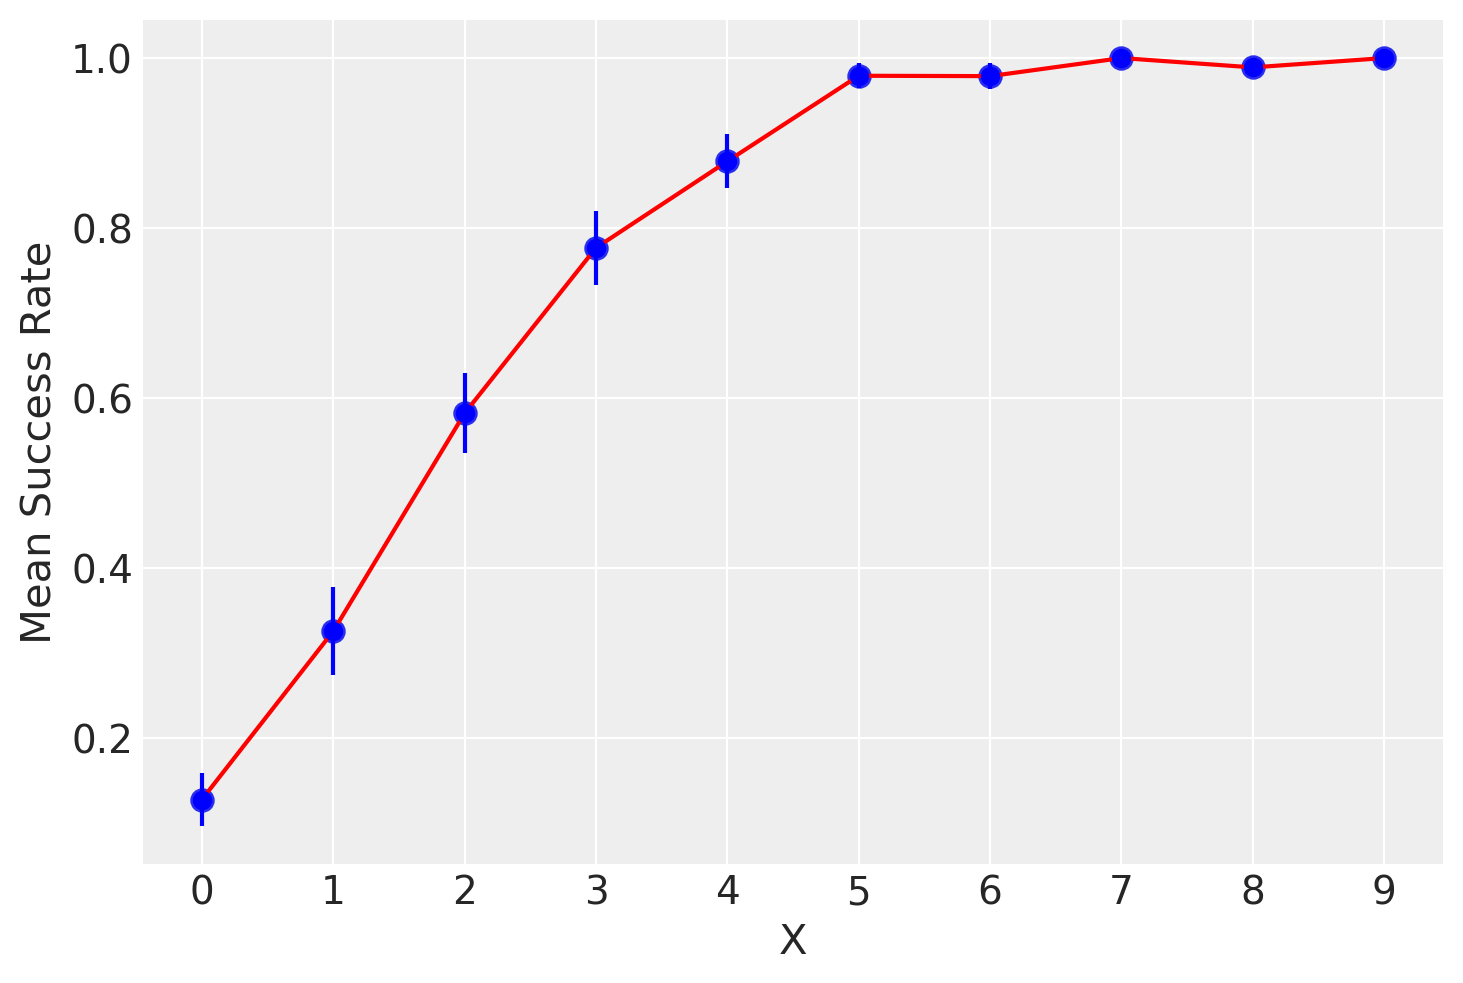

In [8]:
# Simulate data
np.random.seed(42)  # For reproducibility
n = 1000  # Number of samples
X = np.random.randint(0, 10, size=n)  # Discrete independent variable with levels from 0 to 9

# Define the logistic model
def logistic(x, beta0, beta1):
    return expit(beta0 + beta1 * x)

beta0 = -2
beta1 = 1  # Increase the steepness of the curve
p = logistic(X, beta0, beta1)

# Generate dichotomous outcome variable Y
Y = np.random.binomial(1, p, size=n)

# Compute mean success rate and standard error for each level of X
df = pd.DataFrame({'X': X, 'Y': Y})
mean_success_rate = df.groupby('X')['Y'].mean()
standard_error = df.groupby('X')['Y'].sem()

# Plot mean success rates with standard errors
sns.pointplot(x=mean_success_rate.index, y=mean_success_rate.values, capsize=0.1, linestyle='none')  # Use linestyle='none' to avoid connecting lines
plt.errorbar(mean_success_rate.index, mean_success_rate.values, yerr=standard_error.values, fmt='o', color='blue')

# Fit a non-parametric smoother (LOESS) and plot the curve
lowess_smoothed = lowess(mean_success_rate.values, mean_success_rate.index, frac=0.3)

plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', label='Non-parametric Smoother')

# Customizing the plot
plt.xlabel('X')
plt.ylabel('Mean Success Rate')
plt.grid(True)

# Display the plot
plt.show()

## Modello Lineare nelle Probabilità

Potremmo pensare di usare una funzione lineare per rappresentare la dipendenza di $Y$ da $X$. Introduciamo un modello lineare con le seguenti assunzioni standard:

$$
Y_i = \alpha + \beta X_i + \varepsilon_i,
$$

dove $\varepsilon_i$ segue una distribuzione normale con media 0 e varianza 1 ($\varepsilon_i \sim \mathcal{N}(0, 1)$) e gli errori $\varepsilon_i$ e $\varepsilon_j$ sono indipendenti per ogni $i \neq j$. Il valore atteso di $Y_i$ è quindi $\mathbb{E}(Y_i) = \alpha + \beta X_i$, portando a:

$$
\pi_i = \alpha + \beta X_i.
$$

Questo è noto come *modello lineare nelle probabilità* (*linear probability model*). Tuttavia, questo approccio presenta una limitazione significativa: non garantisce che i valori predetti di $\pi_i$ siano confinati nell'intervallo [0,1], come richiesto per le probabilità.

### Problemi di Normalità

Considerando che $Y_i$ può assumere solo i valori 0 o 1, i residui $\varepsilon_i$ risultano anch'essi dicotomici e quindi non possono seguire una distribuzione normale. Ad esempio, se $Y_i=1$ con probabilità $\pi_i$, il residuo sarà:

$$
\varepsilon_i = 1 - \mathbb{E}(Y_i) = 1 - (\alpha + \beta X_i) = 1 - \pi_i.
$$

Se, invece, $Y_i=0$ con probabilità $1-\pi_i$, il residuo sarà:

$$
\varepsilon_i = 0 - \mathbb{E}(Y_i) = 0 - (\alpha + \beta X_i) = - \pi_i.
$$

Tuttavia, se la dimensione del campione è grande, il teorema del limite centrale può mitigare l'importanza dell'assunzione di normalità per le stime dei minimi quadrati.

### Problematiche di Eteroschedasticità

Utilizzare il metodo dei minimi quadrati può essere inappropriato in questo contesto poiché la varianza dei residui non è costante ma dipende dalla media, e quindi dalla variabile $X$. Assumendo che il modello sia lineare, abbiamo che $\mathbb{E}(\varepsilon_i)=0$. Sfruttando le relazioni discusse in precedenza, la varianza dei residui si calcola come:

$$
\mathbb{V}(\varepsilon_i) = (1-\pi_i)\pi_i.
$$

Consideriamo che la varianza dei residui $\varepsilon_i$ può essere espressa come:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2,
$$

dove $\mathbb{E}(\varepsilon_i^2)$ è il valore atteso del quadrato dei residui e $\mathbb{E}(\varepsilon_i)^2$ è il quadrato del valore atteso dei residui.

Ora calcoliamo $\mathbb{E}(\varepsilon_i^2)$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i^2) &= \mathbb{E}[(Y_i - \mathbb{E}(Y_i))^2] \\
&= \mathbb{E}[(Y_i - \pi_i)^2] \\
&= \mathbb{E}[(Y_i^2 - 2Y_i\pi_i + \pi_i^2)] \\
&= \mathbb{E}(Y_i^2) - 2\mathbb{E}(Y_i\pi_i) + \mathbb{E}(\pi_i^2) \\
&= \mathbb{E}(Y_i) - 2\mathbb{E}(Y_i\pi_i) + \pi_i^2 \\
&= \pi_i - 2\pi_i^2 + \pi_i^2 \\
&= \pi_i - \pi_i^2 \\
&= \pi_i(1 - \pi_i)
\end{align*}
$$

Ora calcoliamo $\mathbb{E}(\varepsilon_i)^2$:

$$
\begin{align*}
\mathbb{E}(\varepsilon_i)^2 &= (\mathbb{E}(Y_i - \mathbb{E}(Y_i)))^2 \\
&= (\mathbb{E}(Y_i - \pi_i))^2 \\
&= (0)^2 \\
&= 0
\end{align*}
$$

Quindi, sostituendo questi risultati nella formula della varianza dei residui, otteniamo:

$$
\text{Var}(\varepsilon_i) = \mathbb{E}(\varepsilon_i^2) - \mathbb{E}(\varepsilon_i)^2 = \pi_i(1 - \pi_i)
$$

Quindi, abbiamo dimostrato che la varianza dei residui nel modello lineare nelle probabilità può essere espressa come $(1-\pi_i)\pi_i$.

Dato che $\pi_i$ dipende da $x$, ciò significa che la varianza non è costante in funzione di $x$. Questa eteroschedasticità dei residui rappresenta un problema per le stime dei minimi quadrati nel modello lineare, specialmente quando le probabilità $\pi_i$ sono vicine a 0 o 1.

### Linearità

Il maggiore inconveniente connesso all'adozione del modello lineare nelle probabilità deriva dal fatto che la stima della probabilità di successo, $P(\hat{Y}_i=1)=\hat{\pi}_i$, non è necessariamente compresa nell'intervallo $(0,1)$, ma può essere sia negativa sia maggiore di 1. Nel caso dell'esempio in discussione, ciò significa che la retta dei minimi quadrati produce valori attesi $\hat{\pi}$ inferiori a 0 per bassi valori della variabile $X$ e valori $\hat{\pi}$ superiori a 1 per valori di $X$ alti.

## Modello Lineare nelle Probabilità Vincolato

Una soluzione per mantenere $\pi$ all'interno dell'intervallo (0, 1) è la seguente specificazione del modello:

$$
\pi=
\begin{cases}
  0                           &\text{se $\alpha + \beta X < 0$},\\
  \alpha + \beta X           &\text{se $0 \leq \alpha + \beta X \leq 1$},\\
  1 &\text{se $\alpha + \beta X > 1$}.
\end{cases}
$$

Questo *modello lineare nelle probabilità vincolato* mostra alcune instabilità, soprattutto a causa della sua dipendenza critica dai valori estremi di $\pi$, dove assume i valori 0 o 1. La linearità di $\pi = \alpha + \beta X$ si basa fortemente sui punti in cui si verificano questi estremi. In particolare, la stima di $\pi = 0$ può essere influenzata dal valore minimo di $X$ associato a $Y=1$, mentre la stima di $\pi = 1$ può dipendere dal valore massimo di $X$ per cui $Y=0$. Questi valori estremi tendono a variare significativamente tra diversi campioni e possono diventare più estremi all'aumentare della dimensione del campione.

La presenza di più variabili esplicative ($k \geq 2$) complica ulteriormente la stima dei parametri del modello. Inoltre, il modello mostra un cambiamento brusco nella pendenza della curva di regressione ai punti estremi (0 e 1 di $\pi$), risultando poco realistico in molte situazioni pratiche. Questo rende il modello meno adatto a descrivere relazioni complesse e gradualmente variabili tra $\pi$ e $X$.

Una funzione che modella una relazione più fluida e continua tra $\pi$ e $X$ sarebbe più realistica e rappresentativa delle dinamiche osservate. Questo motiva la preferenza per modelli alternativi, come il modello di regressione logistica, che tende a fornire una rappresentazione più accurata e realistica delle interazioni tra variabili dicotomiche e esplicative.

## Regressione Logistica

Un metodo efficace per gestire il problema del vincolo sulle probabilità è specificare modelli non direttamente per le probabilità stesse, ma per una loro trasformazione che elimina tale vincolo. Invece di definire un modello lineare per la probabilità condizionata $\pi_i$, si può specificare un modello lineare per il logaritmo degli odds (logit):

$$
\eta_i = \log_e \frac{\pi_i}{1-\pi_i} = \alpha + \beta x_i,
$$

Questo approccio non presenta problemi poiché il logit $\eta_i$ è sempre un numero reale, permettendo di modellare una trasformazione lineare di $\pi_i$. La trasformazione inversa, che ci permette di ottenere $\pi_i$ da $\eta_i$, è data dalla funzione logistica:

$$
\pi_i = \frac{e^{\eta_i}}{1 + e^{\eta_i}} = \frac{e^{\alpha + \beta x_i}}{1 + e^{\alpha + \beta x_i}}.
$$

### Vantaggi della Regressione Logistica

La regressione logistica presenta diversi vantaggi rispetto al modello lineare delle probabilità:

1. **Vincolo delle Probabilità:** La trasformazione logistica assicura che i valori predetti di $\pi_i$ siano sempre compresi nell'intervallo [0,1].
2. **Interpretabilità degli Odds Ratio:** Il coefficiente $\beta$ può essere interpretato come il cambiamento logaritmico negli odds di successo associato a un incremento unitario di $X$. In altre parole, $e^\beta$ rappresenta il fattore di aumento (o diminuzione) degli odds per un incremento unitario della variabile indipendente.
3. **Gestione dell'Eteroschedasticità:** La forma funzionale della varianza del modello di regressione logistica $\pi_i (1 - \pi_i)$ è intrinsecamente considerata nel processo di stima tramite il metodo della massima verosimiglianza.

### Esempio Pratico

Per illustrare l'applicazione della regressione logistica, consideriamo nuovamente i dati simulati precedentemente. Applichiamo il modello di regressione logistica ai dati e tracciamo la curva logistica risultante:

Optimization terminated successfully.
         Current function value: 0.289256
         Iterations 8


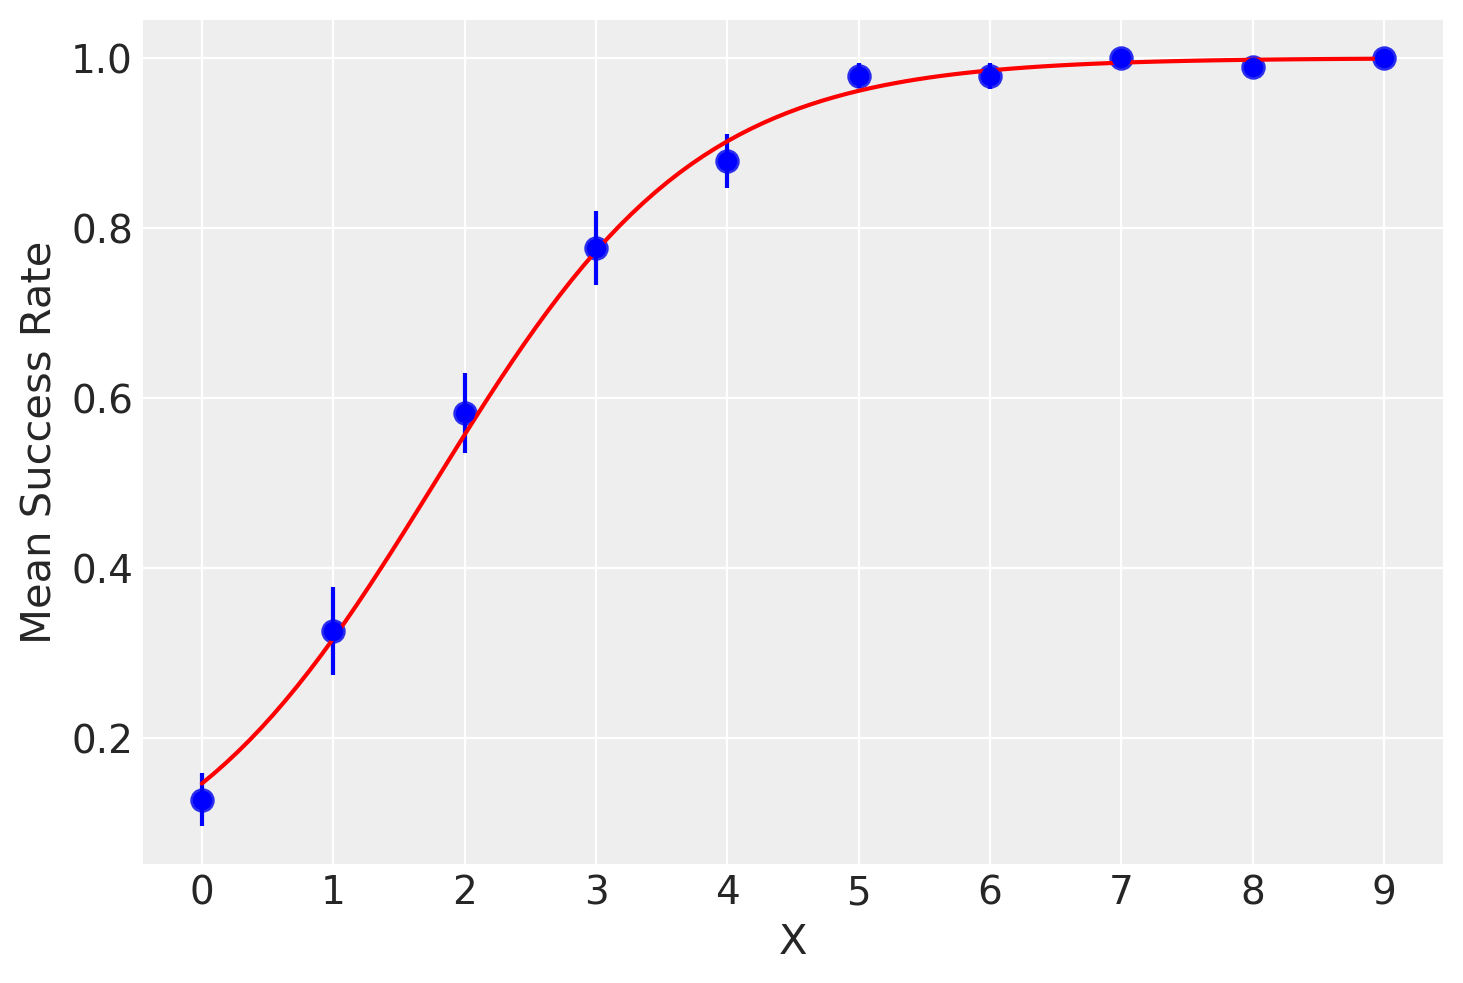

In [17]:
# Plot mean success rates with standard errors
sns.pointplot(x=mean_success_rate.index, y=mean_success_rate.values, capsize=0.1, linestyle='none')  # Use linestyle='none' to avoid connecting lines
plt.errorbar(mean_success_rate.index, mean_success_rate.values, yerr=standard_error.values, fmt='o', color='blue')

# Fit logistic regression model and plot logistic curve
X_design = sm.add_constant(X)
logit_model = sm.Logit(Y, X_design).fit()
x_vals = np.linspace(X.min(), X.max(), 100)
y_vals = logit_model.predict(sm.add_constant(x_vals))

plt.plot(x_vals, y_vals, color='red', label='Logistic Regression Curve')

# Customizing the plot
plt.xlabel('X')
plt.ylabel('Mean Success Rate')
plt.grid(True)

# Display the plot
plt.show()

Questo esempio dimostra come la regressione logistica possa essere utilizzata per modellare una variabile dicotomica in funzione di una variabile indipendente. La curva logistica risultante rappresenta adeguatamente la relazione tra $X$ e la probabilità di successo $Y$, garantendo che i valori predetti di $\pi_i$ siano sempre compresi nell'intervallo [0,1].

Nelle sezioni seguenti, descriveremo in dettaglio il modello di regressione logistica utilizzato per generare la curva logistica mostrata nella figura precedente. Inizieremo chiarendo i concetti di odds e logit e la loro relazione con le probabilità.

## Componente Sistematica

La componente sistematica mette in relazione un vettore ($\eta_1, \eta_2, \dots, \eta_k$) con le variabili esplicative mediante un modello lineare. Sia $X_{ij}$ il valore della $j$-esima variabile esplicativa ($j=1, 2, \dots, p$) per l'$i$-esima osservazione ($i=1, \dots, k$). Allora 

$$
\eta_i = \sum_j \beta_j X_{ij}.
$$

Questa combinazione lineare di variabili esplicative è chiamata il *predittore lineare*. Un $X_{ij}=1, \forall i$ viene utilizzato per il coefficiente dell'intercetta del modello (talvolta denotata da $\alpha$).

## Componente Aleatoria

La  componente aleatoria del modello suppone l'esistenza di
  $k$ osservazioni indipendenti $y_1, y_2, \dots, y_k$, ciascuna delle
  quali viene trattata come la realizzazione di una variabile casuale
  $Y_i$. Si assume che $Y_i$ abbia una distribuzione binomiale:

$$
Y_i \sim Bin(n_i, \pi_i)
$$

con parametri $n_i$ e $\pi_i$. Per dati individuali (uno per ciascun valore $x_i$), $n_i=1,
    \forall i$.
  
## Funzione Legame

La  funzione legame $g(\cdot)$  mette in relazione il valore atteso della variabile risposta $Y_i$ con la componente sistematica $\eta_i$ del modello. Abbiamo visto che $\mathbb{E}(Y_i)=\pi_i$.
Che relazione c'è tra $\pi_i$ e il predittore lineare $\eta_i= \alpha + \sum_j  \beta_j X_{ij}$? 
La risposta a questa domanda è data dalla funzione legame:

$$
\eta_i = g(\pi_i) = \ln{\frac{\pi_i}{1-\pi_i}}
$$

Si noti che la funzione legame non trasforma la variabile risposta $Y_i$ ma bensì il suo valore atteso $\pi_i$.

La funzione legame è invertibile: anziché trasformare il valore atteso nel predittore lineare si può trasformare il predittore lineare nel valore atteso $\pi_i$:

$$
\pi_i = \frac{e^{\eta_i}}{1+e^{\eta_i}} =  \frac{e^{\alpha + \sum_j  \beta_j X_{ij}}}{1+e^{\alpha + \sum_j  \beta_j X_{ij}}}.
$$

Si ottiene così un modello non lineare per le probabilità $\pi_i$.

In conclusione, la regressione logistica estende il concetto di regressione lineare per modellare le probabilità condizionate di esiti Bernoulliani $ Y $, adoperando la funzione logistica come collegamento per trasformare relazioni lineari tra predittori ($ \eta_i = \beta_0 + \beta_1 X_{i} $) in probabilità nell'intervallo [0,1]. Questo metodo permette di passare dalla modellazione diretta della probabilità $ p $ alla modellazione di una funzione di tale probabilità attraverso una relazione lineare, impiegando la funzione logit come funzione di collegamento.

## Coefficienti del Modello nella Regressione Logistica e la loro Interpretazione

Un aspetto cruciale per comprendere la relazione tra le variabili predittive e una variabile di risposta binaria è l'interpretazione dei coefficienti del modello.

### Odds Ratio

Il caso più semplice che consente di interpetare l'odds ratio in una regressione logistica è quando la variabile indipendente (X) è binaria (cioè può assumere solo valori 0 e 1).

In una regressione logistica, il modello assume la forma:

$$
\log \left( \frac{P(Y = 1)}{P(Y = 0)} \right) = \beta_0 + \beta_1 X
$$

dove:

- $\log \left( \frac{P(Y = 1)}{P(Y = 0)} \right)$ è il logaritmo dell'odds che l'evento $Y = 1$ avvenga,
- $\beta_0$ è l'intercetta del modello,
- $\beta_1$ è il coefficiente per la variabile indipendente $X$.

### Passo 1: Calcolare gli odds per i due valori di $X$

Quando $X = 0$, l'equazione diventa:

$$
\log \left( \frac{P(Y = 1 \mid X = 0)}{P(Y = 0 \mid X = 0)} \right) = \beta_0
$$

Questo significa che l'odds di $Y = 1$ dato che $X = 0$ è:

$$
\frac{P(Y = 1 \mid X = 0)}{P(Y = 0 \mid X = 0)} = e^{\beta_0}
$$

Allo stesso modo, quando $X = 1$, l'equazione diventa:

$$
\log \left( \frac{P(Y = 1 \mid X = 1)}{P(Y = 0 \mid X = 1)} \right) = \beta_0 + \beta_1
$$

Quindi, l'odds di $Y = 1$ dato che $X = 1$ è:

$$
\frac{P(Y = 1 \mid X = 1)}{P(Y = 0 \mid X = 1)} = e^{\beta_0 + \beta_1}
$$

### Passo 2: Calcolare l’odds ratio

L'odds ratio è il rapporto tra gli odds quando $X = 1$ e quando $X = 0$:

$$
\text{Odds Ratio} = \frac{\frac{P(Y = 1 \mid X = 1)}{P(Y = 0 \mid X = 1)}}{\frac{P(Y = 1 \mid X = 0)}{P(Y = 0 \mid X = 0)}} = \frac{e^{\beta_0 + \beta_1}}{e^{\beta_0}}
$$

Semplificando, otteniamo:

$$
\text{Odds Ratio} = e^{\beta_1}
$$

### Interpretazione dell'odds ratio

L’odds ratio $e^{\beta_1}$ rappresenta il cambiamento relativo negli odds di $Y = 1$ per un aumento di una unità di $X$ (in questo caso, il passaggio da $X = 0$ a $X = 1$). 

Se $\beta_1$ è:

- **Maggiore di zero** ($e^{\beta_1} > 1$): l’odds di $Y = 1$ aumenta quando $X$ passa da 0 a 1.
- **Minore di zero** ($e^{\beta_1} < 1$): l’odds di $Y = 1$ diminuisce quando $X$ passa da 0 a 1.
- **Uguale a zero** ($e^{\beta_1} = 1$): l’odds di $Y = 1$ non cambia in base ai valori di $X$.

In sintesi, l’odds ratio $e^{\beta_1}$ fornisce una misura dell’associazione tra la variabile binaria $X$ e la probabilità dell’evento $Y = 1$, rappresentando il moltiplicatore degli odds nel caso in cui $X$ passi da 0 a 1.

### Interpretazione sui Logit

Nella regressione logistica, ogni coefficiente $\beta_j$ del modello può essere interpretato direttamente in termini di log-odds, che sono i logaritmi delle probabilità di ottenere un evento con esito positivo ($y=1$). Quando interpretiamo i coefficienti:

- **Coefficienti Positivi ($\beta_j > 0$)**: Un coefficiente positivo indica che c'è una relazione diretta tra il predittore e l'aumento dei log-odds di osservare l'evento di interesse. Questo significa che all'aumentare del valore del predittore, la probabilità dell'evento di interesse aumenta.
  
- **Coefficienti Negativi ($\beta_j < 0$)**: Al contrario, un coefficiente negativo indica una relazione inversa tra il predittore e la probabilità logistica dell'evento. Con l'aumentare del predittore, i log-odds e quindi la probabilità dell'evento diminuiscono.

### Interpretazione sugli Odds Ratio (OR)

L'interpretazione dei coefficienti nella regressione logistica può estendersi agli odds ratio (OR), che forniscono informazioni sulla relazione tra i predittori e la probabilità dell'evento di interesse. Per esempio, consideriamo un modello con un predittore continuo $X$ e un coefficiente $\beta_1 = 0.50$. Il logaritmo naturale dell'odds ratio, $\log(OR) = 0.50$, viene esponenziato per ottenere:

$$
OR = e^{0.50} \approx 1.65.
$$

Questo risultato indica che per un'unità di incremento in $X$, l'odds di sperimentare l'evento di interesse è circa 1.65 volte maggiore. In altre parole, l'incremento di una unità nel predittore $X$ aumenta l'odds di sperimentare l'evento di interesse di circa il 65%. Viceversa, un coefficiente negativo indicherebbe una diminuzione dell'odds per un incremento di una unità in $X$.

### Interpretazione sulla Scala delle Probabilità

La regressione logistica consente di interpretare i coefficienti non solo in termini di log-odds, ma anche relativamente alle variazioni di probabilità. Consideriamo un modello che predice la probabilità di superare un esame basandosi sul numero di ore di studio ($X$).

Supponiamo che il coefficiente associato alle ore di studio sia $\beta_1 = 0.5$. Questo valore indica che ogni ora aggiuntiva di studio incrementa i log-odds di successo nell'esame. Per comprendere l'impatto di un'ora in più di studio sulla probabilità di successo, possiamo utilizzare la seguente formula:

$$
\Delta p = \frac{1}{1 + e^{-(\beta_0 + 0.5 \cdot (X_1 + 1))}} - \frac{1}{1 + e^{-(\beta_0 + 0.5 \cdot X_1)}}.
$$

Questa formula calcola la differenza tra la probabilità di successo dopo aver aggiunto un'ora di studio e la probabilità di successo prima di tale aggiunta. In termini pratici, $\Delta p$ rappresenta l'incremento della probabilità di superare l'esame attribuibile a un'ora supplementare di studio. Questa interpretazione è cruciale per valutare quantitativamente l'effetto delle ore di studio sulla probabilità di superare l'esame.

## Un esempio concreto

Consideriamo nuovamente i dati simulati in precedenza

In [18]:
df.head()

,X,Y
0,6,1
1,3,1
2,7,1
3,4,1
4,6,1


Stimeremo ora i coefficienti del modello di regressione logistica usando Stan. Definiamo i dati nel formato atteso da Stan:

In [19]:
stan_data = {
    "N" : df.shape[0],
    "y" : df["Y"],
    "x" : df["X"] 
}

Compiliamo il modello di regressione logistica e stampiamo lo script Stan:

In [20]:
stan_file = os.path.join(project_directory, "stan", "logistic_regression.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

12:47:02 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/logistic_regression.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/logistic_regression
12:47:13 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/logistic_regression


data {
  int<lower=0> N;
  vector[N] x;
  array[N] int<lower=0, upper=1> y;
}
parameters {
  real alpha;
  real beta;
}
model {
  y ~ bernoulli_logit(alpha + beta * x);
}



Eseguiamo il campionamento MCMC:

In [21]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

12:47:36 - cmdstanpy - INFO - CmdStan start processing
12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:36 - cmdstanpy - INFO - Chain [2] start processing
12:47:36 - cmdstanpy - INFO - Chain [3] start processing
12:47:36 - cmdstanpy - INFO - Chain [4] start processing
12:47:37 - cmdstanpy - INFO - Chain [3] done processing
12:47:37 - cmdstanpy - INFO - Chain [2] done processing
12:47:37 - cmdstanpy - INFO - Chain [4] done processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing


Esaminiamo le tracce:

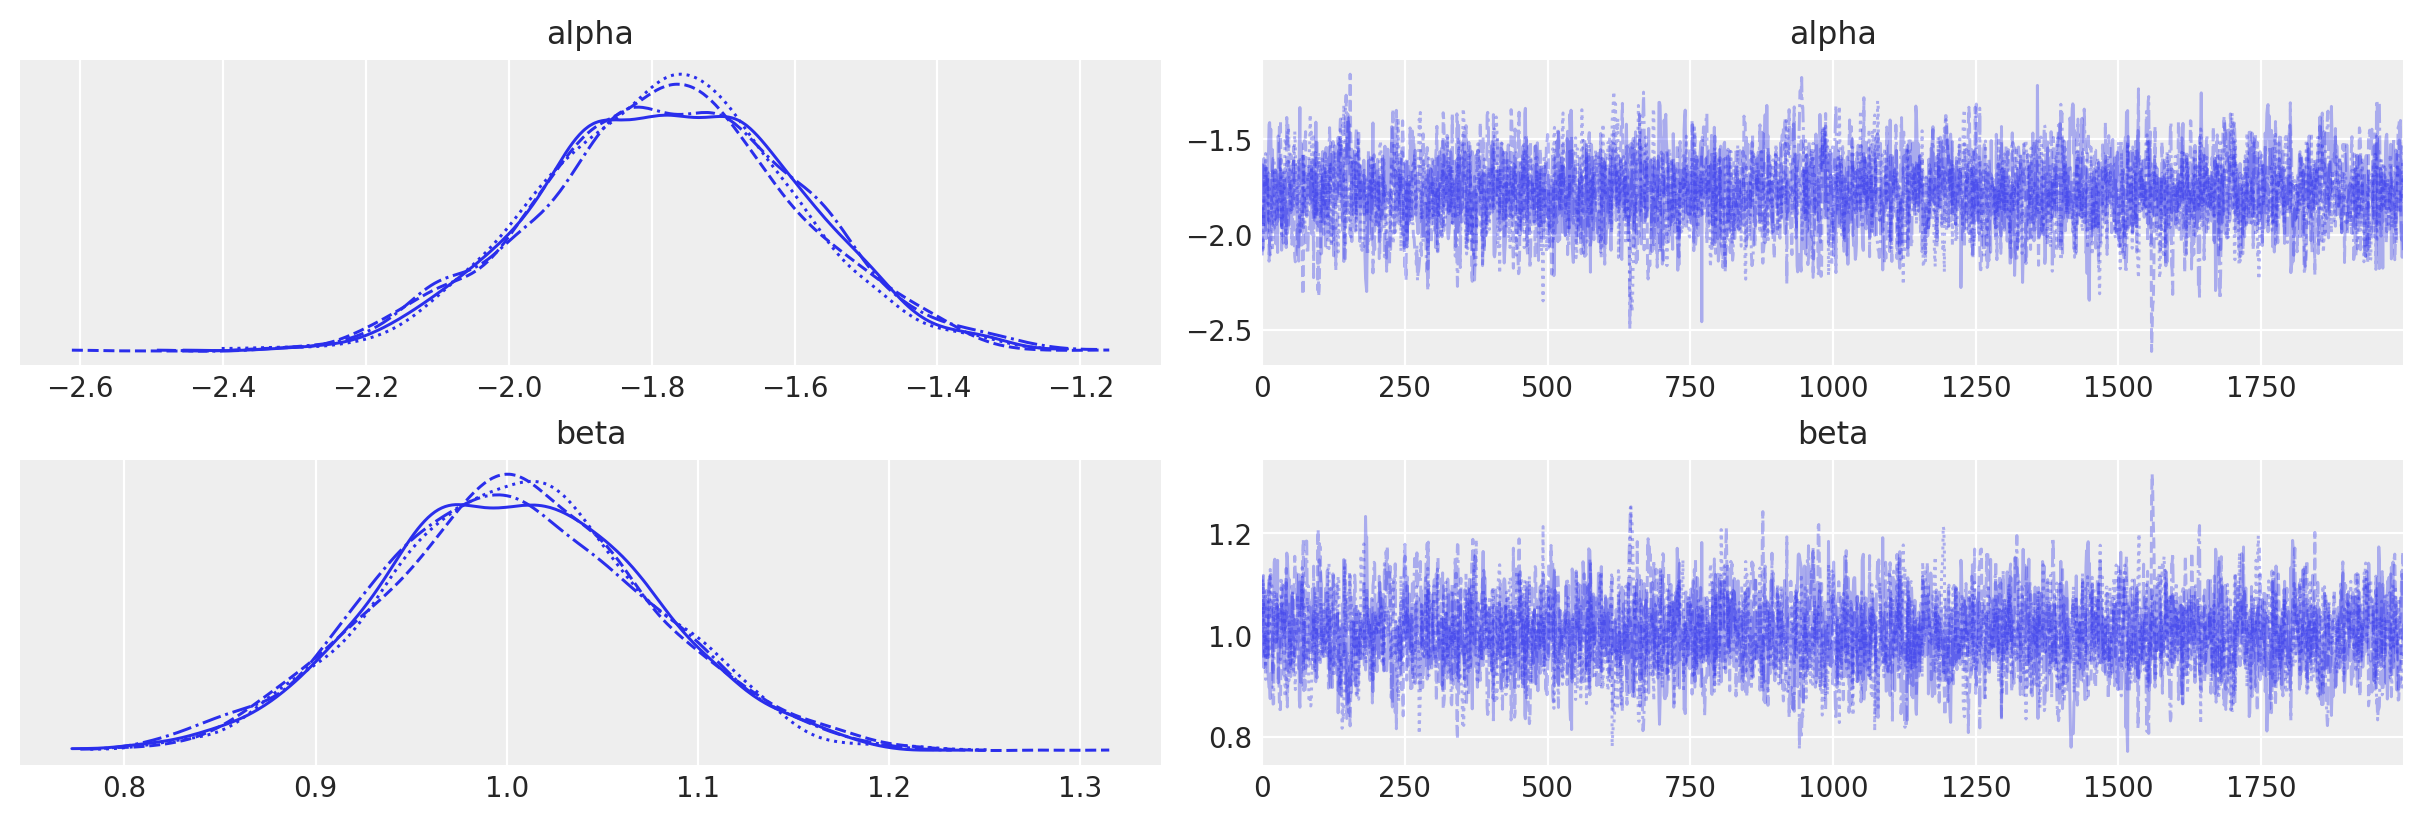

In [22]:
_ = az.plot_trace(fit)

Otteniamo le stime a posteriori dei parametri:

In [23]:
az.summary(fit, var_names=(["alpha", "beta"]), hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.778,0.18,-2.132,-1.436,0.004,0.003,2261.0,2634.0,1.0
beta,1.004,0.07,0.869,1.144,0.001,0.001,2305.0,2682.0,1.0


Creiamo un nuovo DataFrame con 100 valori $x$ nell'intervallo [0, 9]:

In [24]:
new_data = pd.DataFrame({
    "x": np.linspace(0, 9, 100)
})
new_data

,x
0,0.000000
1,0.090909
2,0.181818
3,0.272727
4,0.363636
...,...
95,8.636364
96,8.727273
97,8.818182
98,8.909091


Otteniamo le medie a posteriori dei parametri $\alpha$ e $\beta$:

In [25]:
alpha = fit.stan_variable('alpha').mean()
beta = fit.stan_variable('beta').mean() 
print(alpha, beta)

-1.7784477 1.003503126


Calcoliamo i logit per ogni valore $ x $ nel dataset `new_data` utilizzando le stime a posteriori dei parametri $\alpha$ e $\beta$ ottenute dal modello di regressione logistica. Nel modello di regressione logistica, il logit della probabilità è una funzione lineare di $ x $:

$$
\log \left( \frac{p}{1-p} \right) = \alpha + \beta x
$$

In [26]:
logit_p = alpha + new_data['x'] * beta
logit_p

0    -1.778448
1    -1.687220
2    -1.595993
3    -1.504765
4    -1.413537
        ...   
95    6.888170
96    6.979398
97    7.070625
98    7.161853
99    7.253080
Name: x, Length: 100, dtype: float64

Esaminiamo graficamente la relazione tra il logit $\log \left( \frac{p}{1-p} \right)$ e $x$:

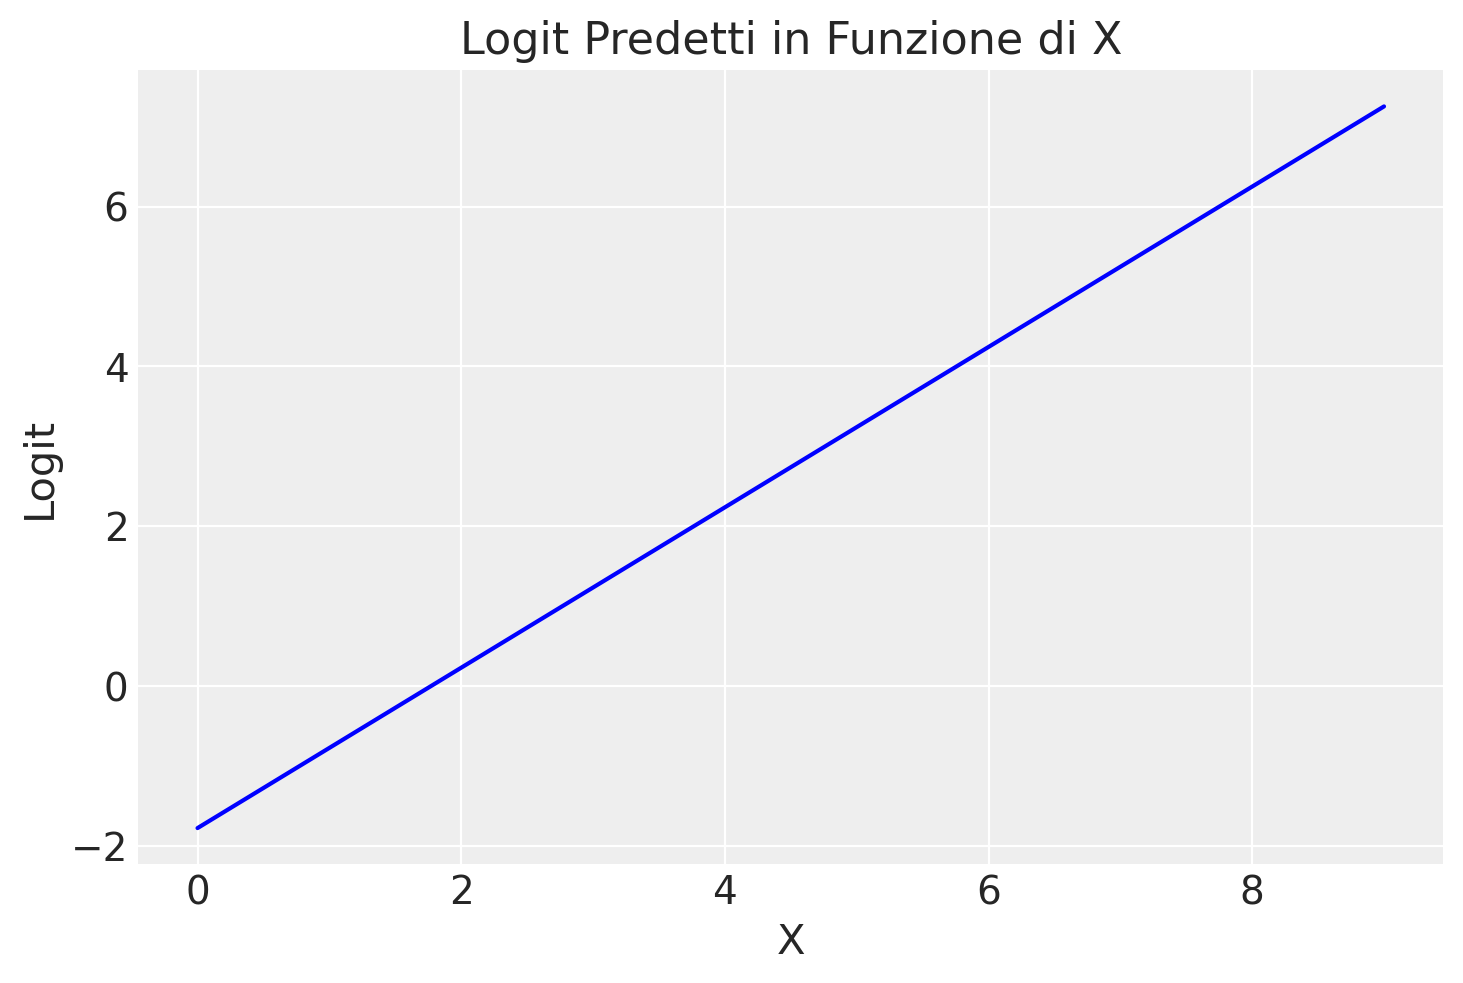

In [27]:
new_data['logit_p'] = logit_p

plt.plot(new_data['x'], new_data['logit_p'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Logit Predetti in Funzione di X')  # Titolo del grafico
plt.xlabel('X')  # Etichetta asse x
plt.ylabel('Logit')  # Etichetta asse y
plt.show() 

Calcoliamo i logit per ogni valore $ x $ nel dataset `new_data` utilizzando le stime a posteriori dei parametri $\alpha$ e $\beta$ ottenute dal modello di regressione logistica. Nel modello di regressione logistica, il logit della probabilità è una funzione lineare di $ x $. Per ottenere la probabilità $ p $ dalla trasformazione del logit, possiamo utilizzare la funzione logistica inversa. Svolgiamo la conversione:

1. Calcoliamo il logit per ogni valore di $ x $:

   $$
   \text{logit}_p = \alpha + \beta x
   $$

2. Applichiamo la funzione logistica inversa (antilogit) per ottenere la probabilità $ p $:

   $$
   p = \frac{e^{\text{logit}_p}}{1 + e^{\text{logit}_p}} = \frac{e^{\alpha + \beta x}}{1 + e^{\alpha + \beta x}}
   $$

Questa formula ci permette di trasformare il logit in una probabilità compresa tra 0 e 1 per ogni valore di $ x $ nel dataset `new_data`.

In [28]:
prob = np.exp(logit_p) / (1 + np.exp(logit_p))
# Aggiungi le probabilità calcolate a `new_data`
new_data['prob'] = prob
new_data.head()

,x,logit_p,prob
0,0.000000,-1.778448,0.144495
1,0.090909,-1.687220,0.156142
2,0.181818,-1.595993,0.168542
3,0.272727,-1.504765,0.181716
4,0.363636,-1.413537,0.195677


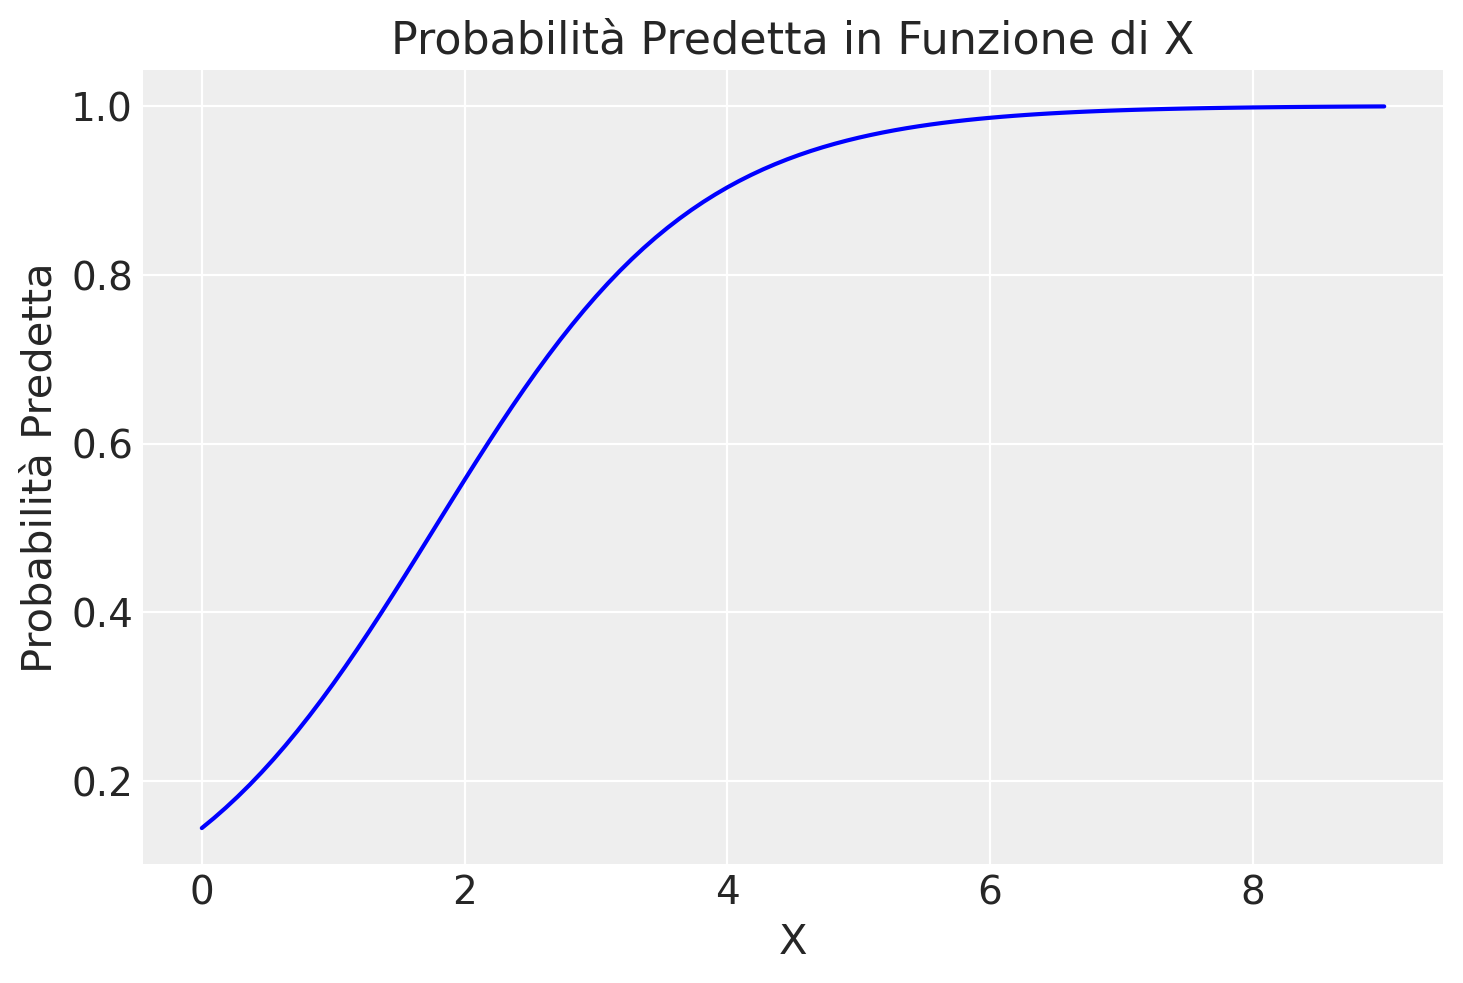

In [29]:
plt.plot(new_data['x'], new_data['prob'], linestyle='-', color='blue')  # Plot con marcatori e linea

plt.title('Probabilità Predetta in Funzione di X')  # Titolo del grafico
plt.xlabel('X')  # Etichetta asse x
plt.ylabel('Probabilità Predetta')  # Etichetta asse y
plt.show() 

### Interpretazione dei Coefficienti nella Regressione Logistica

Abbiamo stimato i coefficienti $\alpha$ e $\beta$ dal modello di regressione logistica con i seguenti valori:
- $\alpha = -1.7784477$
- $\beta = 1.003503126$

Esamineremo ora l'interpretazione di questi coefficienti sulla scala dei logit, dell'odds ratio e delle probabilità.


#### La regola del dividere per 4

La regola del dividere per 4 è un metodo utile per interpretare i coefficienti della regressione logistica. Dividendo il coefficiente $\beta$ per 4, si ottiene un'approssimazione della massima variazione nella probabilità $\Pr(y = 1)$ per un incremento unitario in $ x $, in corrispondenza di $ p = 0.5 $.

La curva logistica è più ripida al centro, dove $ \alpha + \beta x = 0 $ e quindi $ \text{logit}^{-1}(\alpha + \beta x) = 0.5 $. In questo punto, la pendenza della curva, ovvero la derivata della funzione logistica, è massima e raggiunge il valore $ \beta / 4 $.

Per esempio, nel modello con $ \alpha = -1.778 $ e $ \beta = 1.003 $, dividendo $\beta$ per 4 otteniamo circa 0.25. Questo valore rappresenta l'aumento massimo, in termini di probabilità, che possiamo aspettarci per un incremento unitario in $ x $, in corrispondenza di $ p = 0.5 $.

In sintesi, la regola del dividere per 4 semplifica l'interpretazione dei coefficienti della regressione logistica, fornendo un'indicazione intuitiva di come la variabile indipendente influisce sulla probabilità dell'evento di interesse.


#### Scala dei Logit

Nella regressione logistica, la funzione logit rappresenta una relazione lineare tra il logit della probabilità di successo e la variabile indipendente $X$:

$$
\log \left( \frac{p}{1-p} \right) = \alpha + \beta x
$$

Con i coefficienti stimati, la funzione logit diventa:

$$
\log \left( \frac{p}{1-p} \right) = -1.7784477 + 1.003503126 \cdot x
$$

- **$\alpha = -1.7784477$**: Questo è l'intercetta del modello, il valore del logit quando $x = 0$. Indica che, quando $x$ è 0, il logit della probabilità di successo è $-1.7784477$.
- **$\beta = 1.003503126$**: Questo è il coefficiente di $x$ e rappresenta il cambiamento nel logit per ogni incremento unitario in $x$. In altre parole, per ogni incremento di 1 unità in $x$, il logit della probabilità di successo aumenta di circa $1.003503126$.

#### Odds Ratio

L'odds ratio (OR) misura il cambiamento relativo nelle odds di successo per un incremento unitario in $x$. È ottenuto esponenziando il coefficiente $\beta$:

$$
\text{OR} = e^{\beta} = e^{1.003503126} \approx 2.728
$$

Un odds ratio di circa $2.728$ indica che, per ogni incremento unitario in $x$, le odds di successo aumentano di circa $172.8\%$. In altre parole, l'odds di successo è circa $2.728$ volte maggiore per ogni unità aggiuntiva di $x$.

#### Scala delle Probabilità

Per interpretare l'effetto di $\beta$ sulla scala delle probabilità, possiamo considerare come la probabilità $p$ cambia in corrispondenza di specifici valori di $x$.

1. Quando $x = 0$:

$$
\log \left( \frac{p}{1-p} \right) = -1.7784477
$$

Invertendo il logit per ottenere $p$:

$$
p = \frac{e^{-1.7784477}}{1 + e^{-1.7784477}} \approx \frac{0.169} {1 + 0.169} \approx 0.144
$$

Quindi, la probabilità di successo quando $x = 0$ è circa $14.4\%$.

2. Per un incremento unitario in $x$, diciamo $x = 1$:

$$
\log \left( \frac{p}{1-p} \right) = -1.7784477 + 1.003503126 \cdot 1 \approx -0.774944574
$$

Invertendo il logit per ottenere $p$:

$$
p = \frac{e^{-0.774944574}}{1 + e^{-0.774944574}} \approx \frac{0.461} {1 + 0.461} \approx 0.316
$$

Quindi, la probabilità di successo quando $x = 1$ è circa $31.6\%$. Tuttavia questo incremento non è costante per i diversi livelli $x$ e il modo più semplice per mostrare la relazione tra probabilità di successo e la variabile $X$ è quella di generare un grafico come quello che abbimo prodotto in precedenza.

### Riassunto

- **Scala dei Logit**: Un incremento unitario in $x$ aumenta il logit della probabilità di successo di $1.003503126$.
- **Odds Ratio**: Le odds di successo aumentano di circa $2.728$ volte per ogni incremento unitario in $x$.
- **Scala delle Probabilità**: Quando $x$ passa da 0 a 1, la probabilità di successo aumenta da circa $14.4\%$ a $31.6\%$. Per la relazione tra ciascun livello $x$ e la probabilità di successo è necessario generare un grafico.

Questa analisi dimostra come i coefficienti del modello di regressione logistica possono essere interpretati su diverse scale, fornendo un quadro completo della relazione tra la variabile indipendente e la probabilità di successo.

## Regressione logistica con solo l'intercetta

La regressione lineare con solo l'intercetta è equivalente a stimare una media e la regressione lineare con un singolo predittore binario è equivalente a stimare una differenza tra medie. Allo stesso modo, la regressione logistica con solo l'intercetta è equivalente alla stima di una proporzione.

Ecco un esempio. Un campione casuale di 50 persone viene testato e 10 di loro manifestano una certa caratteristica psicologica. La proporzione è 0.20 con errore standard $ \sqrt{0.2 \cdot 0.8 / 50} = 0.06 $. In alternativa, possiamo impostare questo come regressione logistica usando Bambi in Python:

In [30]:
# Dati
y = [0]*40 + [1]*10
df = pd.DataFrame({'y': y})

# Modello
model = bmb.Model('y ~ 1', data=df, family='bernoulli')
fit = model.fit(nuts_sampler="numpyro", random_seed=123)

Modeling the probability that y==1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [31]:
az.summary(fit, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.39,0.35,-2.05,-0.73,0.01,0.01,1524.26,1636.18,1.0


Possiamo trasformare la previsione nella scala delle probabilità e ottenere un risultato che è essenzialmente lo stesso della stima classica con incertezza di 0.20 ± 0.06.

In [32]:
# Given values
intercept = -1.4
error = 0.35

# Calculate logit^-1(-1.41)
p_hat = expit(intercept)

# Calculate logit^-1(-1.41 ± 0.36)
lower_bound = expit(intercept - error)
upper_bound = expit(intercept + error)

print(f'p_hat: {p_hat:.3f}, Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}')

p_hat: 0.198, Lower bound: 0.148, Upper bound: 0.259


Le stime classiche e quelle della regressione logistica differiscono leggermente, in parte perché Bambi usa una distribuzione a priori e in parte perché l'errore standard classico è solo un'approssimazione all'incertezza inferenziale derivante dai dati discreti.

## Regressione logistica con un singolo predittore binario

La regressione logistica su una variabile indicatrice è equivalente a un confronto di proporzioni. Per un esempio semplice, consideriamo i test per una malattia su campioni provenienti da due popolazioni diverse, dove 10 su 50 individui della popolazione A risultano positivi, rispetto a 20 su 60 della popolazione B. La stima classica è 0.13 con errore standard di 0.08. Ecco come impostare questo caso come regressione logistica utilizzando Bambi in Python:

In [33]:
# Dati
x = [0] * 50 + [1] * 60
y = [0] * 40 + [1] * 10 + [0] * 40 + [1] * 20
df = pd.DataFrame({'x': x, 'y': y})

# Definire il modello
model = bmb.Model('y ~ x', data=df, family='bernoulli')

# Adattare il modello con un seed
fit = model.fit(nuts_sampler="numpyro", random_seed=123)

Modeling the probability that y==1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [34]:
# Visualizzare i risultati del fit
az.summary(fit, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.41,0.36,-2.07,-0.74,0.01,0.01,2661.46,2476.84,1.0
x,0.71,0.45,-0.09,1.60,0.01,0.01,3115.18,2554.46,1.0


Per ottenere l'inferenza per la differenza di probabilità, confrontiamo le previsioni sulla scala delle probabilità per $ x = 0 $ e $ x = 1 $:

In [35]:
# Given values
intercept = -1.41
slope = 0.71

# Calculate probabilities for x = 0 and x = 1
logit_0 = intercept
logit_1 = intercept + slope

prob_0 = expit(logit_0)
prob_1 = expit(logit_1)

# Calculate the difference in probabilities
diff = prob_1 - prob_0

prob_0, prob_1, diff
print(f'prob_0: {prob_0:.3f}, prob_1: {prob_1:.3f}, difference: {diff:.3f}')

prob_0: 0.196, prob_1: 0.332, difference: 0.136


Per l'errore standard possiamo eseguire la seguente simulazione:

In [36]:
# Given values
intercept_mean = -1.41
slope_mean = 0.71
intercept_sd = 0.36
slope_sd = 0.45

# Number of simulations
num_simulations = 10000

# Generate samples of the coefficients
intercept_samples = np.random.normal(intercept_mean, intercept_sd, num_simulations)
slope_samples = np.random.normal(slope_mean, slope_sd, num_simulations)

# Calculate the corresponding probabilities
prob_0_samples = expit(intercept_samples)
prob_1_samples = expit(intercept_samples + slope_samples)

# Calculate the difference in probabilities for each sample
diff_samples = prob_1_samples - prob_0_samples

# Calculate the mean and standard deviation of the differences
mean_diff = np.mean(diff_samples)
std_diff = np.std(diff_samples)

mean_diff, std_diff
print(f'difference: {mean_diff:.3f}, standard error: {std_diff:.3f}')

difference: 0.140, standard error: 0.096


Sebbene abbiamo ottenuto un errore standard di circa 0.095, che è leggermente diverso dall'errore standard di 0.08 menzionato inizialmente, questo valore riflette l'incertezza nelle stime dei coefficienti fornite. Potrebbero esserci delle variazioni dovute al metodo di campionamento utilizzato. Tuttavia, questi calcoli dimostrano l'approccio corretto per stimare l'errore standard utilizzando la simulazione Monte Carlo con le deviazioni standard dei coefficienti stimati. ​

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanp

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanp: not installed

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

arviz      : 0.18.0
seaborn    : 0.13.2
matplotlib : 3.9.1
scipy      : 1.14.0
statsmodels: 0.14.2
pandas     : 2.2.2
numpy      : 1.26.4
bambi      : 0.14.0

Watermark: 2.4.3

